In [ ]:
# importing required libraries
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
# loading the flower dataset
(ds_train, ds_test), ds_info = tfds.load('tf_flowers',
                                          split =['train[:80%]', 'train[80:]'],
                                                  shuffle_files=True,
                                                  as_supervised=True,
                                                  with_info=True
                                                  )

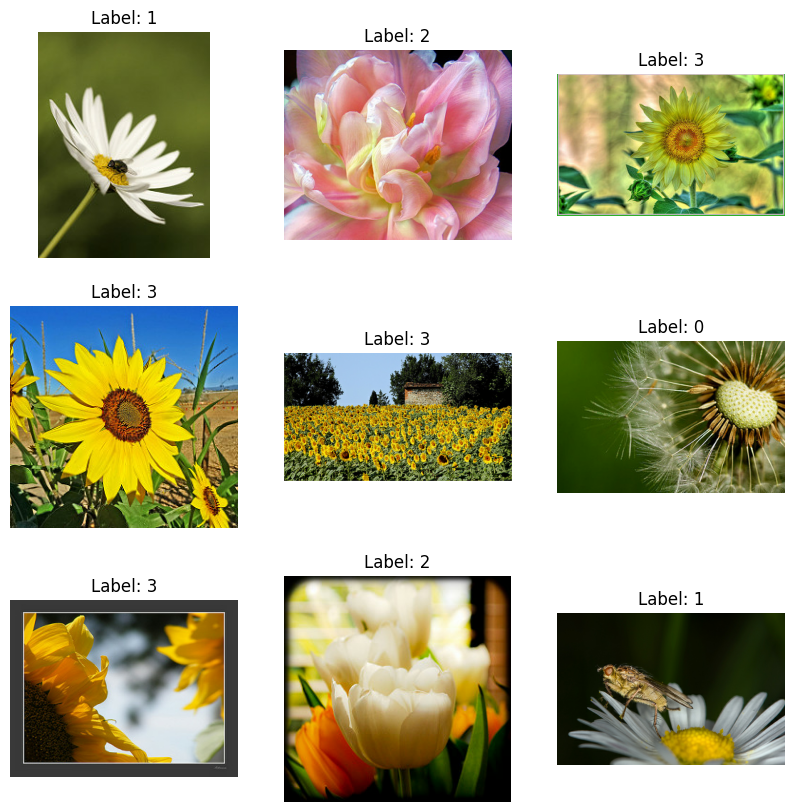

In [ ]:
# Plot 9 sample images
plt.figure(figsize=(10, 10))
for i, (image, label) in enumerate(ds_train.take(9)):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(f"Label: {label.numpy()}")
    plt.axis("off")

In [ ]:
IMG_SIZE = 180
BATCH_SIZE = 32

In [ ]:
# preprocessing function
def preprocess(image,label):
  image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
  image = tf.cast(image, tf.float32) / 255.0
  return image, label

In [ ]:
#preprocessing and batching
train_ds = (
    ds_train
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

test_ds = (
    ds_test
    .map(preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    .cache()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# defining the model
model = keras.Sequential([
                          layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3)),
                          layers.Conv2D(16, 3, activation='relu'),
                          layers.MaxPooling2D(),
                          layers.Conv2D(32, 3, activation='relu'),
                          layers.MaxPooling2D(),
                          layers.Conv2D(64, 3, activation='relu'),
                          layers.MaxPooling2D(),
                          layers.Flatten(),
                          layers.Dense(64, activation='relu'),
                          layers.Dense(ds_info.features['label'].num_classes,activation='softmax')
                          ])

In [ ]:
#compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# train the model
history = model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=5
)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 131s 1s/step - accuracy: 0.3629 - loss: 1.4415 - val_accuracy: 0.5142 - val_loss: 1.1092
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - accuracy: 0.5598 - loss: 1.0825 - val_accuracy: 0.6574 - val_loss: 0.8990
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.6639 - loss: 0.8827 - val_accuracy: 0.6593 - val_loss: 0.8209
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - accuracy: 0.7246 - loss: 0.7167 - val_accuracy: 0.7802 - val_loss: 0.6195
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 115s 1s/step - accuracy: 0.8002 - loss: 0.5324 - val_accuracy: 0.8571 - val_loss: 0.4493


In [ ]:
#converting the trained model to tensorflow lite format
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the converted model to file
with open("flower_model.tflite", "wb") as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp62cwa7dt'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name='keras_tensor_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  134422573452176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422573452944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422682074960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422573453136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422573453520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422573450064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422573452752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422573453328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422573454864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  134422573455824: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
#checking the file size
import os

print("TFLite model size (KB):", os.path.getsize("flower_model.tflite") / 1024)

TFLite model size (KB): 6497.53125


In [ ]:
#loading the TFLite model
interpreter = tf.lite.Interpreter(model_path="flower_model.tflite")
interpreter.allocate_tensors()  # Prepare the model for inference


In [ ]:
#getting input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

print("Input shape:", input_details[0]['shape'])
print("Input type:", input_details[0]['dtype'])


Input shape: [  1 180 180   3]
Input type: <class 'numpy.float32'>


In [ ]:
import numpy as np

# Take one image from the test dataset
for image, label in ds_test.take(1):
    img = tf.image.resize(image, [180, 180]) / 255.0
    img = tf.expand_dims(img, axis=0)  # Add batch dimension: [1, 180, 180, 3]
    true_label = label.numpy()
    break


In [ ]:
#running inference prediction
interpreter.set_tensor(input_details[0]['index'], img.numpy())
interpreter.invoke()  # Run the model

# Get the output prediction
output = interpreter.get_tensor(output_details[0]['index'])
predicted_label = np.argmax(output)

print("True Label:", true_label)
print("Predicted Label:", predicted_label)


True Label: 1
Predicted Label: 1
